Notebook currently works only for the data in 'dataset' folder. 

To train & test a model, first change model_name in 'mount drive, initialize variables and import packages', then run sections:
- mount drive, initialize variables and import package
- cxn_model.py
- train & test.py
- save trained model
- metrices.py
possibly: - plot predicted cloud masks

To test a saved model, first check model_name in 'mount drive, initialize variables and import packages', then run sections:
- mount drive, initialize variables and import package
- cxn_model.py
- test model
- metrices.py
possibly: - plot predicted cloud masks

# mount drive, initialize variables and import packages


In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
dataset = 'dataset' # name of folder
path_data = '/content/drive/MyDrive/CloudXNet/' + dataset + '/'
print(path_data)

model_name = '1125v0_model' # month, day, version, _model
path_model = '/content/drive/MyDrive/CloudXNet/saved_models/' + model_name
print(path_model)

/content/drive/MyDrive/CloudXNet/dataset/
/content/drive/MyDrive/CloudXNet/saved_models/1125v0_model


In [3]:
# imports
# cxn_model
from keras.models import Model
from keras.layers import *
import keras
from tensorflow.keras.optimizers import *

from keras import backend as K

# train & test
import os
import tensorflow as tf
from tensorflow import keras
import random
from keras.callbacks import TensorBoard
# from keras import backend as K
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from tqdm import tqdm 
import numpy as np
from PIL import Image

# metrices
from sklearn.metrics import confusion_matrix

# 38-cloud
import pandas as pd

In [ ]:
pip install rioxarray


     |████████████████████████████████| 46 kB 2.1 MB/s eta 0:00:011
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.3 MB 9.0 MB/s 
     |████████████████████████████████| 19.3 MB 349 kB/s 
  Created wheel for rioxarray: filename=rioxarray-0.9.0-py3-none-any.whl size=54395 sha256=a4c0eea13f5e9cb9745f47251628d8105536ebb7a8b7f78234613b26fbb7355e
  Stored in directory: /root/.cache/pip/wheels/f2/0d/f2/29da7ed804b71eb1317c3683b373f59d7c0c4c501117f2b144
Successfully built rioxarray


In [ ]:
pip install earthpy

     |████████████████████████████████| 1.4 MB 5.9 MB/s 
     |████████████████████████████████| 1.0 MB 34.6 MB/s 
     |████████████████████████████████| 15.4 MB 36.3 MB/s 


In [ ]:
import rioxarray as rxr
import xarray as xr
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

# Some visualisations


random indices: [160, 44]
original image 160 of size (512, 512)


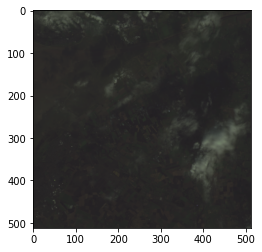

resized image 160 of size (256, 256)


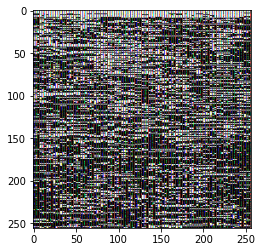

original gt 160 of size (512, 512)


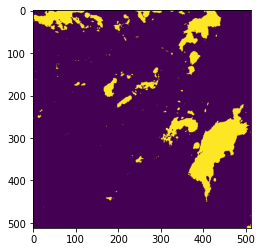

resized gt 160 of size 65536


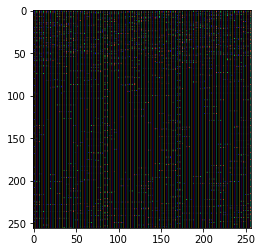

original image 44 of size (512, 512)


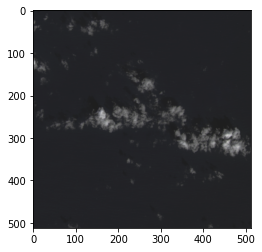

resized image 44 of size (256, 256)


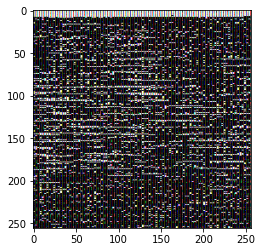

original gt 44 of size (512, 512)


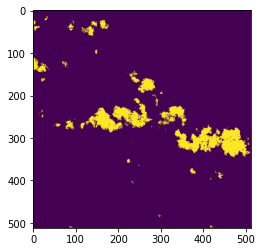

resized gt 44 of size 65536


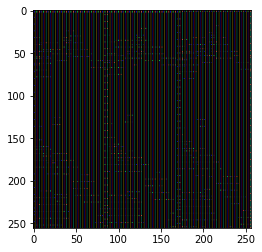

In [ ]:
# dataset
# visualize training data, ground truth & rescaling

number_of_visualisations = 2
IMG_HEIGHT = 256
IMG_WIDTH = 256

random_indices = random.sample(range(0,350), number_of_visualisations)
print('random indices: ' + str(random_indices))
 
TRAIN_PATH_R = path_data + 'B4/train/'  #change path 
TRAIN_PATH_G = path_data + 'B3/train/'
TRAIN_PATH_B = path_data + 'B2/train/'

GT_PATH = path_data + 'BQA/train/'
 
for ind in random_indices:
       red    = Image.open(TRAIN_PATH_R + str(ind) + '.png').convert('L')
       green  = Image.open(TRAIN_PATH_G + str(ind) + '.png').convert('L')
       blue   = Image.open(TRAIN_PATH_B + str(ind) + '.png').convert('L')
       
       rgb = Image.merge("RGB",(red,green,blue))
       print('original image ' + str(ind) + ' of size ' + str(rgb.size))
       plt.imshow(rgb)
       plt.show()
       img_r = np.asarray(rgb) 
       img_r = resize(img_r, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
       img_r_img = Image.fromarray(img_r, 'RGB') # own idea to realize an image plot
       print('resized image ' + str(ind) + ' of size ' + str(img_r_img.size))
       plt.imshow(img_r_img)
       plt.show()      

       gt = Image.open(GT_PATH + str(ind) + '.png')
       print('original gt ' + str(ind) + ' of size ' + str(gt.size))
       plt.imshow(gt)
       plt.show()
       gt_r = np.array(gt) 
       gt_r = resize(gt_r, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       gt_r_img = Image.fromarray(gt_r, 'RGB') # own idea to realize an image plot
       print('resized gt ' + str(ind) + ' of size ' + str(gt_r.size))
       plt.imshow(gt_r_img)
       plt.show()




In [ ]:
# dataset_38
# visualize training data, ground truth & rescaling (38-Cloud)

#number_of_visualisations = 2
IMG_HEIGHT = 384
IMG_WIDTH = 384

#random_indices = random.sample(range(0,10), number_of_visualisations)
#print('random indices: ' + str(random_indices))

TRAIN_FOLDER = path_data + '38-Cloud_training/' 
TRAIN_PATH_R = path_data + '38-Cloud_training/train_red'  #change path 
TRAIN_PATH_G = path_data + '38-Cloud_training/train_green'
TRAIN_PATH_B = path_data + '38-Cloud_training/train_blue'

GT_PATH = path_data + '38-Cloud_training/train_gt'

def get_input_image_names(list_names, directory_name, if_train=True):
    list_img = []
    list_msk = []
    list_test_ids = []

    for filenames in tqdm(list_names['name'], miniters=1000):
        nred = 'red_' + filenames
        nblue = 'blue_' + filenames
        ngreen = 'green_' + filenames

        if if_train:
            dir_type_name = "train"
            fl_img = []
            nmask = 'gt_' + filenames
            fl_msk = directory_name + '/train_gt/' + '{}.TIF'.format(nmask)
            list_msk.append(fl_msk)

        else:
            dir_type_name = "test"
            fl_img = []
            fl_id = '{}.TIF'.format(filenames)
            list_test_ids.append(fl_id)

        fl_img_red = directory_name + '/' + dir_type_name + '_red/' + '{}.TIF'.format(nred)
        fl_img_green = directory_name + '/' + dir_type_name + '_green/' + '{}.TIF'.format(ngreen)
        fl_img_blue = directory_name + '/' + dir_type_name + '_blue/' + '{}.TIF'.format(nblue)
        fl_img.append(fl_img_red)
        fl_img.append(fl_img_green)
        fl_img.append(fl_img_blue)

        list_img.append(fl_img)

    if if_train:
        return list_img, list_msk
    else:
        return list_img, list_test_ids

train_patches_csv_name = 'training_patches_38-Cloud.csv'
df_train_img = pd.read_csv(os.path.join(TRAIN_FOLDER, train_patches_csv_name))
train_img, train_msk = get_input_image_names(df_train_img, TRAIN_FOLDER, if_train=True)

100%|██████████| 100/100 [00:00<00:00, 172960.99it/s]


In [ ]:
train_patches_csv_name_ne = 'training_patches_38-cloud_nonempty.csv'
df_train_img_ne = pd.read_csv(os.path.join(TRAIN_FOLDER, train_patches_csv_name_ne))

lst_non_empty = []
for patch in df_train_img['name']:
  lst_non_empty.append       (df_train_img_ne['name'].where(df_train_img_ne['name'] == patch).isna().sum())

print(100*5155 - sum(lst_non_empty))

non_empty = [i for i,x in enumerate(lst_non_empty) if x < 5155]

print(non_empty)

for index in non_empty:
  print(df_train_img['name'][index])

5
[72, 73, 94, 95, 96]
patch_5_1_by_5_LC08_L1TP_002053_20160520_20170324_01_T1
patch_5_1_by_5_LC08_L1TP_002054_20160520_20170324_01_T1
patch_6_1_by_6_LC08_L1TP_029040_20160720_20170222_01_T1
patch_6_1_by_6_LC08_L1TP_032029_20160420_20170223_01_T1
patch_6_1_by_6_LC08_L1TP_034034_20160520_20170223_01_T1


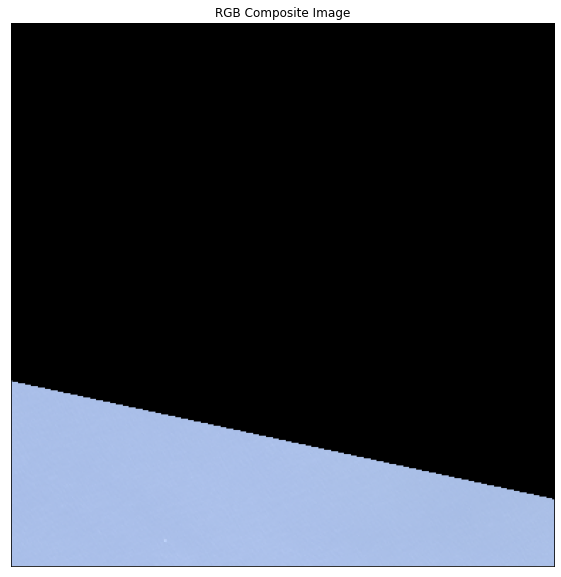

/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


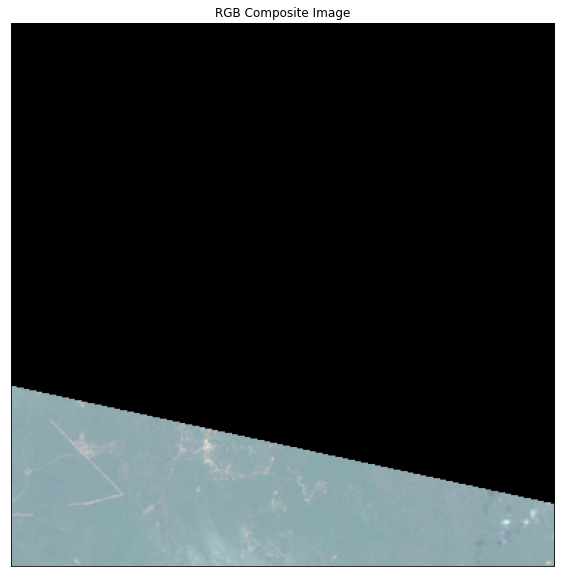

/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


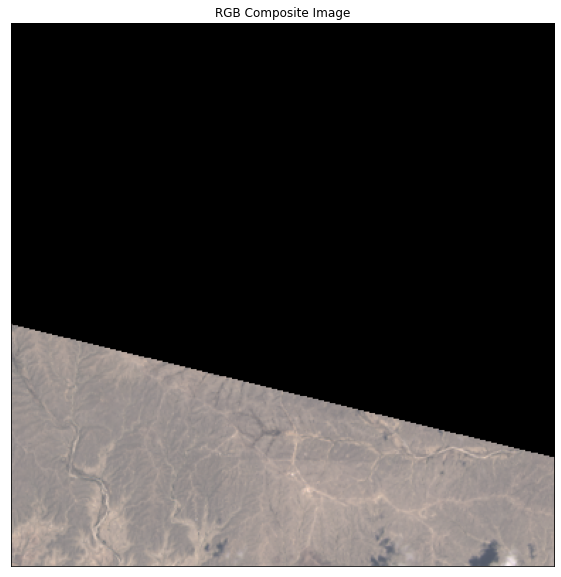

/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


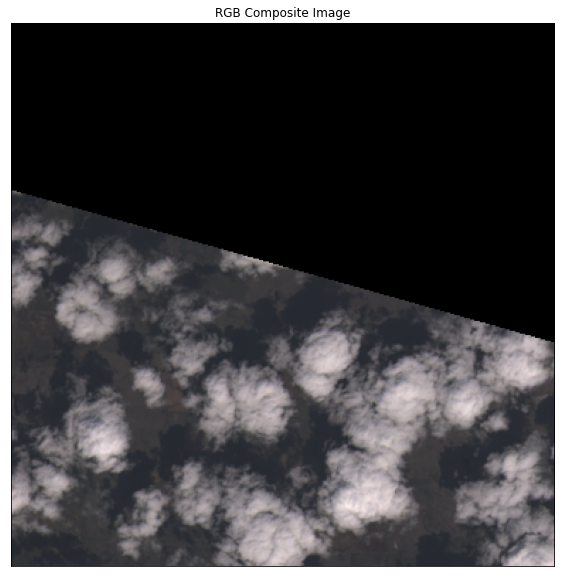

/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))
/usr/local/lib/python3.7/dist-packages/rioxarray/_io.py:841: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))


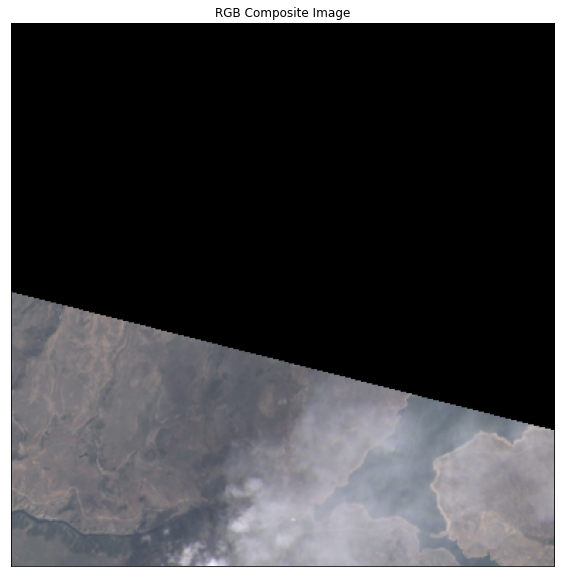

In [ ]:
# print('Length train_img ' + str(len(train_img)))

# number_of_visualisations = 3
# random_indices = random.sample(range(0,len(train_img)), number_of_visualisations)
# print('random indices: ' + str(random_indices))
def open_clean_bands(band_path):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.
        
    Returns
    -------
    An single xarray object with the Landsat band data.

    """
     
    return rxr.open_rasterio(band_path, masked=True).squeeze()

for ind in non_empty:
  # band_g = rxr.open_rasterio(train_img[ind][1], masked=True).squeeze()
  # band_g.shape
  # f, ax = plt.subplots()
  # band_g.plot.imshow(ax=ax, cmap='Greys_r')
  # ax.set_axis_off()
  # ax.set_title("Plot of Band Green")
  # Open all bands in a loop
  all_bands = []
  for i, aband in enumerate(train_img[ind]):
    all_bands.append(open_clean_bands(aband))
    # Assign a band number to the new xarray object
    all_bands[i]["band"]=i+1
  train_img_xr = xr.concat(all_bands, dim ='band')
  ep.plot_rgb(train_img_xr.values, rgb = [0, 1, 2], title='RGB Composite Image')
  plt.show()

# cxn_model.py


In [4]:
# from keras.models import Model
# from keras.layers import *
# import keras
# from tensorflow.keras.optimizers import *

# from keras import backend as K

smooth = 0.0000001

def aspp(x,out_shape):
    b0=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(x)
    b0=BatchNormalization()(b0)
    b0=Activation("relu")(b0)

    #b5=DepthwiseConv2D((3,3),dilation_rate=(3,3),padding="same",use_bias=False)(x)
    #b5=BatchNormalization()(b5)
    #b5=Activation("relu")(b5)
    #b5=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b5)
    #b5=BatchNormalization()(b5)
    #b5=Activation("relu")(b5)

    b1=DepthwiseConv2D((3,3),dilation_rate=(6,6),padding="same",use_bias=False)(x)
    b1=BatchNormalization()(b1)
    b1=Activation("relu")(b1)
    b1=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b1)
    b1=BatchNormalization()(b1)
    b1=Activation("relu")(b1)

    b2=DepthwiseConv2D((3,3),dilation_rate=(12,12),padding="same",use_bias=False)(x)
    b2=BatchNormalization()(b2)
    b2=Activation("relu")(b2)
    b2=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b2)
    b2=BatchNormalization()(b2)
    b2=Activation("relu")(b2)	

    b3=DepthwiseConv2D((3,3),dilation_rate=(18,18),padding="same",use_bias=False)(x)
    b3=BatchNormalization()(b3)
    b3=Activation("relu")(b3)
    b3=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b3)
    b3=BatchNormalization()(b3)
    b3=Activation("relu")(b3)

    b4=AveragePooling2D(pool_size=(out_shape,out_shape))(x)
    b4=SeparableConv2D(256,(1,1),padding="same",use_bias=False)(b4)
    b4=BatchNormalization()(b4)
    b4=Activation("relu")(b4)
    b4=UpSampling2D((out_shape,out_shape), interpolation='bilinear')(b4)
    x=Concatenate()([b4,b0,b1,b2,b3])
    return x

def jacc_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - ((intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + smooth))

def bn_relu(input_tensor):
    """It adds a Batch_normalization layer before a Relu
    """
    input_tensor = BatchNormalization(axis=3)(input_tensor)
    return Activation("relu")(input_tensor)


def contr_arm(input_tensor, filters, kernel_size):
    """It adds a feedforward signal to the output of two following conv layers in contracting path
       TO DO: remove keras.layers.add and replace it with add only
    """

    x = SeparableConv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernel size of (1,1) out of (3,3)

    x1 = SeparableConv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def imprv_contr_arm(input_tensor, filters, kernel_size ):
    """It adds a feedforward signal to the output of two following conv layers in contracting path
    """

    x = SeparableConv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x0 = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x0 = bn_relu(x0)

    x = SeparableConv2D(filters, kernel_size, padding='same')(x0)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 = SeparableConv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)

    x2 = SeparableConv2D(filters, kernel_size_b, padding='same')(x0)
    x2 = bn_relu(x2)

    x = keras.layers.add([x, x1, x2])
    x = Activation("relu")(x)
    return x


def bridge(input_tensor, filters, kernel_size):
    """It is exactly like the identity_block plus a dropout layer. This block only uses in the valley of the UNet
    """

    x = SeparableConv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = SeparableConv2D(filters, kernel_size, padding='same')(x)
    x = Dropout(.15)(x)
    x = bn_relu(x)

    filters_b = filters // 2
    kernel_size_b = (kernel_size[0]-2, kernel_size[0]-2)  # creates a kernl size of (1,1) out of (3,3)

    x1 =SeparableConv2D(filters_b, kernel_size_b, padding='same')(input_tensor)
    x1 = bn_relu(x1)

    x1 = concatenate([input_tensor, x1], axis=3)
    x = keras.layers.add([x, x1])
    x = Activation("relu")(x)
    return x


def conv_block_exp_path(input_tensor, filters, kernel_size):
    """It Is only the convolution part inside each expanding path's block
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    return x


def conv_block_exp_path3(input_tensor, filters, kernel_size):
    """It Is only the convolution part inside each expanding path's block
    """

    x = Conv2D(filters, kernel_size, padding='same')(input_tensor)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)

    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = bn_relu(x)
    return x


def add_block_exp_path(input_tensor1, input_tensor2, input_tensor3):
    """It is for adding two feed forwards to the output of the two following conv layers in expanding path
    """

    x = keras.layers.add([input_tensor1, input_tensor2, input_tensor3])
    x = Activation("relu")(x)
    return x


def improve_ff_block4(input_tensor1, input_tensor2 ,input_tensor3, input_tensor4, pure_ff):
    """It improves the skip connection by using previous layers feature maps
       TO DO: shrink all of ff blocks in one function/class
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
        x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    for ix in range(7):
        if ix == 0:
            x3 = input_tensor3
        x3 = concatenate([x3, input_tensor3], axis=3)
    x3 = MaxPooling2D(pool_size=(8, 8))(x3)

    for ix in range(15):
        if ix == 0:
            x4 = input_tensor4
        x4 = concatenate([x4, input_tensor4], axis=3)
    x4 = MaxPooling2D(pool_size=(16, 16))(x4)

    x = keras.layers.add([x1, x2, x3, x4, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block3(input_tensor1, input_tensor2, input_tensor3, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    for ix in range(7):
        if ix == 0:
            x3 = input_tensor3
        x3 = concatenate([x3, input_tensor3], axis=3)
    x3 = MaxPooling2D(pool_size=(8, 8))(x3)

    x = keras.layers.add([x1, x2, x3, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block2(input_tensor1, input_tensor2, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    for ix in range(3):
        if ix == 0:
            x2 = input_tensor2
        x2 = concatenate([x2, input_tensor2], axis=3)
    x2 = MaxPooling2D(pool_size=(4, 4))(x2)

    x = keras.layers.add([x1, x2, pure_ff])
    x = Activation("relu")(x)
    return x


def improve_ff_block1(input_tensor1, pure_ff):
    """It improves the skip connection by using previous layers feature maps
    """

    for ix in range(1):
        if ix == 0:
            x1 = input_tensor1
        x1 = concatenate([x1, input_tensor1], axis=3)
    x1 = MaxPooling2D(pool_size=(2, 2))(x1)

    x = keras.layers.add([x1, pure_ff])
    x = Activation("relu")(x)
    return x


def model_arch(input_rows=256, input_cols=256, num_of_channels=3, num_of_classes=1):
    inputs = Input((input_rows, input_cols, num_of_channels))
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)

    conv1 = contr_arm(conv1, 32, (3, 3))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = contr_arm(pool1, 64, (3, 3))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = contr_arm(pool2, 128, (3, 3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = contr_arm(pool3, 256, (3, 3))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = imprv_contr_arm(pool4, 512, (3, 3))
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5)

    conv6 = bridge(pool5, 1024, (3, 3))
    
    conv6  = aspp(conv6,input_rows/32)

    convT7 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv6)
    prevup7 = improve_ff_block4(input_tensor1=conv4, input_tensor2=conv3, input_tensor3=conv2, input_tensor4=conv1, pure_ff=conv5)
    up7 = concatenate([convT7, prevup7], axis=3)
    conv7 = conv_block_exp_path3(input_tensor=up7, filters=512, kernel_size=(3, 3))
    conv7 = add_block_exp_path(conv7, conv5, convT7)

    convT8 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv7)
    prevup8 = improve_ff_block3(input_tensor1=conv3, input_tensor2=conv2, input_tensor3=conv1, pure_ff=conv4)
    up8 = concatenate([convT8, prevup8], axis=3)
    conv8 = conv_block_exp_path(input_tensor=up8, filters=256, kernel_size=(3, 3))
    conv8 = add_block_exp_path(input_tensor1=conv8, input_tensor2=conv4, input_tensor3=convT8)

    convT9 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv8)
    prevup9 = improve_ff_block2(input_tensor1=conv2, input_tensor2=conv1, pure_ff=conv3)
    up9 = concatenate([convT9, prevup9], axis=3)
    conv9 = conv_block_exp_path(input_tensor=up9, filters=128, kernel_size=(3, 3))
    conv9 = add_block_exp_path(input_tensor1=conv9, input_tensor2=conv3, input_tensor3=convT9)

    convT10 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv9)
    prevup10 = improve_ff_block1(input_tensor1=conv1, pure_ff=conv2)
    up10 = concatenate([convT10, prevup10], axis=3)
    conv10 = conv_block_exp_path(input_tensor=up10, filters=64, kernel_size=(3, 3))
    conv10 = add_block_exp_path(input_tensor1=conv10, input_tensor2=conv2, input_tensor3=convT10)

    convT11 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv10)
    up11 = concatenate([convT11, conv1], axis=3)
    conv11 = conv_block_exp_path(input_tensor=up11, filters=32, kernel_size=(3, 3))
    conv11 = add_block_exp_path(input_tensor1=conv11, input_tensor2=conv1, input_tensor3=convT11)

    conv12 = Conv2D(num_of_classes, (1, 1), activation='sigmoid')(conv11)

    return Model(inputs=[inputs], outputs=[conv12])



#model = model_arch(input_rows=384, input_cols=384, num_of_channels=3, num_of_classes=1)
#model.compile(optimizer = Adam(lr = 1e-4), loss = jacc_coef, metrics = [jacc_coef,'accuracy'])
#len(model.layers)


# train & test.py


In [ ]:
# import os
# import tensorflow as tf
# from tensorflow import keras
# import random
# from keras.callbacks import TensorBoard
# #from keras import backend as K
# from skimage.io import imread, imshow
# from skimage.transform import resize
# import matplotlib.pyplot as plt
# from tqdm import tqdm 
# import numpy as np
# from PIL import Image
#from cxn_model import *
 
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
 
TRAIN_PATH_R = path_data + 'B4/train/'  #change path 
TRAIN_PATH_G = path_data + 'B3/train/'
TRAIN_PATH_B = path_data + 'B2/train/'
 
TEST_PATH_R = path_data + 'B4/test/'
TEST_PATH_G = path_data + 'B3/test/'
TEST_PATH_B = path_data + 'B2/test/'
 
X_train = np.zeros((350, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((350, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
 
tr=np.zeros(350)
te=np.zeros(10)
 
for i in range(350):
       tr[i]=i;
for i in range(10):
       te[i]=i;
 
 
for n, id_ in tqdm(enumerate(tr),total=350):
       red    = Image.open(TRAIN_PATH_R + str(int(id_)) + '.png').convert('L')
       green  = Image.open(TRAIN_PATH_G + str(int(id_)) + '.png').convert('L')
       blue   = Image.open(TRAIN_PATH_B + str(int(id_)) + '.png').convert('L')
       
       rgb = Image.merge("RGB",(red,green,blue))
       img_b = np.asarray(rgb) 
       
       #img_r = imread(TRAIN_PATH_R + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       #img_g = imread(TRAIN_PATH_G + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       #img_b = imread(TRAIN_PATH_B + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
 
       #img_r = resize(img_r, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #img_g = resize(img_g, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
       img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
       img_b=img_b/255.0
       #for i in range(256):
       #       img[i] = np.concatenate((img_r[i],img_g[i],img_b[i]), axis=1)
       
       X_train[n] = img_b
       
       #mask = Image.open('/content/drive/My Drive/Colab Notebooks/dataset/BQA/train/' + str(int(102+id_)) + '.png').convert('L')
       mask = imread(path_data + 'BQA/train/' + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #mask1 = np.asarray(mask)
       #mask1 = resize(mask1, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
       Y_train[n] =mask1/255.0
       for io in range(256):
         for jo in range(256):
           if (Y_train[n][io][jo]>0.3):
             Y_train[n][io][jo]=1
           else:
             Y_train[n][io][jo]=0
       
 
#for test images 
 
X_test = np.zeros((10, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((10, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []
 
 
for n, id_ in tqdm(enumerate(te),total=10):
       red    = Image.open(TEST_PATH_R + str(170+int(id_)) + '.png').convert('L')
       green  = Image.open(TEST_PATH_G + str(170+int(id_)) + '.png').convert('L')
       blue   = Image.open(TEST_PATH_B + str(170+int(id_)) + '.png').convert('L')
       
       rgb = Image.merge("RGB",(red,green,blue))
       img_b = np.asarray(rgb)  
 
       img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
       img_b=img_b/255.0
       #for i in range(256):
       #       img[i] = np.concatenate((img_r[i],img_g[i],img_b[i]), axis=1)
       
       X_test[n] = img_b
 
       mask = imread(path_data+ 'BQA/test/' + str(int(170+id_)) + '.png')[:,:,:IMG_CHANNELS]
       mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #mask1 = np.asarray(mask)
       #mask1 = resize(mask1, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
       Y_test[n] =mask1/255.0
       for io in range(256):
         for jo in range(256):
           if (Y_test[n][io][jo]>0.3):
             Y_test[n][io][jo]=1
           else:
             Y_test[n][io][jo]=0


model = model_arch(input_rows=384, input_cols=384, num_of_channels=3, num_of_classes=1)
model.compile(optimizer = Adam(lr = 1e-4), loss = jacc_coef, metrics = [jacc_coef,'accuracy'])

#checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5' , verbose=1, save_best_only=True)
#callbacks = [tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss'),tf.keras.callbacks.TensorBoard(log_dir="logs")]

results = model.fit(X_train, Y_train, validation_split=0.05, batch_size=2, epochs=10, verbose=1)   #, callbacks=[cp_callback])

preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.95):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

train_acc = model.evaluate(X_train, Y_train, verbose=1)
test_acc = model.evaluate(X_test, Y_test, verbose=1)


100%|██████████| 10/10 [00:14<00:00,  1.47s/it]
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
166/166 [==============================] - 79s 354ms/step - loss: 0.5555 - jacc_coef: 0.5555 - accuracy: 0.8593 - val_loss: 0.9898 - val_jacc_coef: 0.9898 - val_accuracy: 0.6735
Epoch 2/50
166/166 [==============================] - 57s 346ms/step - loss: 0.3577 - jacc_coef: 0.3577 - accuracy: 0.9417 - val_loss: 0.9999 - val_jacc_coef: 0.9999 - val_accuracy: 0.6735
Epoch 3/50
166/166 [==============================] - 57s 344ms/step - loss: 0.2966 - jacc_coef: 0.2966 - accuracy: 0.9552 - val_loss: 0.9990 - val_jacc_coef: 0.9990 - val_accuracy: 0.6735
Epoch 4/50
166/166 [==============================] - 57s 343ms/step - loss: 0.2708 - jacc_coef: 0.2708 - accuracy: 0.9590 - val_loss: 0.4230 - val_jacc_coef: 0.4230 - val_accuracy: 0.8981
Epoch 5/50
166/166 [==============================] - 57s 343ms/step - loss: 0.2650 - jacc_coef: 0.2650 - accuracy: 0.9606 - val_loss: 0.2119 - val_jacc_coef: 0.2119 - val_accuracy: 0.9552
Epoch 6/50
166/166 [==============================] - 5

# train 38-cloud

In [ ]:
# import os
# import tensorflow as tf
# from tensorflow import keras
# import random
# from keras.callbacks import TensorBoard
# #from keras import backend as K
# from skimage.io import imread, imshow
# from skimage.transform import resize
# import matplotlib.pyplot as plt
# from tqdm import tqdm 
# import numpy as np
# from PIL import Image
#from cxn_model import *
 
IMG_WIDTH = 384
IMG_HEIGHT = 384
IMG_CHANNELS = 3
 
TRAIN_FOLDER = path_data + '38-Cloud_training/' 
TRAIN_PATH_R = path_data + '38-Cloud_training/train_red'  #change path 
TRAIN_PATH_G = path_data + '38-Cloud_training/train_green'
TRAIN_PATH_B = path_data + '38-Cloud_training/train_blue'

GT_PATH = path_data + '38-Cloud_training/train_gt'
 
X_train = np.zeros((100, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((100, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
 
tr=np.zeros(100)
# te=np.zeros(10)
 
for i in range(100):
       tr[i]=i;
# for i in range(10):
#        te[i]=i;
 

for n, id_ in tqdm(enumerate(tr),total=100):
  red    = Image.open(train_img[int(id_)][0]).convert('L')
  green  = Image.open(train_img[int(id_)][1]).convert('L')
  blue   = Image.open(train_img[int(id_)][2]).convert('L')
       
  rgb = Image.merge("RGB",(red,green,blue))
  img_b = np.asarray(rgb) 
       
       #img_r = imread(TRAIN_PATH_R + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       #img_g = imread(TRAIN_PATH_G + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       #img_b = imread(TRAIN_PATH_B + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
 
       #img_r = resize(img_r, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #img_g = resize(img_g, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
  img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
  img_b=img_b/255.0
       #for i in range(256):
       #       img[i] = np.concatenate((img_r[i],img_g[i],img_b[i]), axis=1)
       
  X_train[n] = img_b
       
       #mask = Image.open('/content/drive/My Drive/Colab Notebooks/dataset/BQA/train/' + str(int(102+id_)) + '.png').convert('L')
       #mask = imread(path_data + 'BQA/train/' + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
  mask = Image.open(train_msk[int(id_)]).convert('L')
  mask2 = np.asarray(mask)
  mask1 = resize(mask2, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #mask1 = np.asarray(mask)
       #mask1 = resize(mask1, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
  Y_train[n] =mask1/255.0
  for io in range(256):
   for jo in range(256):
     if (Y_train[n][io][jo]>0.3):
       Y_train[n][io][jo]=1
     else:
       Y_train[n][io][jo]=0
       
 
# # for test images 
 
# X_test = np.zeros((10, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
# Y_test = np.zeros((10, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)
# img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
# sizes_test = []
 
 
# for n, id_ in tqdm(enumerate(te),total=10):
#        red    = Image.open(TEST_PATH_R + str(170+int(id_)) + '.png').convert('L')
#        green  = Image.open(TEST_PATH_G + str(170+int(id_)) + '.png').convert('L')
#        blue   = Image.open(TEST_PATH_B + str(170+int(id_)) + '.png').convert('L')
       
#        rgb = Image.merge("RGB",(red,green,blue))
#        img_b = np.asarray(rgb)  
 
#        img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
#        img_b=img_b/255.0
#        #for i in range(256):
#        #       img[i] = np.concatenate((img_r[i],img_g[i],img_b[i]), axis=1)
       
#        X_test[n] = img_b
 
#        mask = imread(path_data+ 'BQA/test/' + str(int(170+id_)) + '.png')[:,:,:IMG_CHANNELS]
#        mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
#        #mask1 = np.asarray(mask)
#        #mask1 = resize(mask1, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
#        Y_test[n] =mask1/255.0
#        for io in range(256):
#          for jo in range(256):
#            if (Y_test[n][io][jo]>0.3):
#              Y_test[n][io][jo]=1
#            else:
#              Y_test[n][io][jo]=0

model = model_arch(input_rows=384, input_cols=384, num_of_channels=3, num_of_classes=1)
model.compile(optimizer = Adam(lr = 1e-4), loss = jacc_coef, metrics = [jacc_coef,'accuracy'])

#checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5' , verbose=1, save_best_only=True)
#callbacks = [tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss'),tf.keras.callbacks.TensorBoard(log_dir="logs")]

results = model.fit(X_train, Y_train, validation_split=0.05, batch_size=2, epochs=10, verbose=1)   #, callbacks=[cp_callback])

preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.95):], verbose=1)
#preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
#preds_test_t = (preds_test > 0.5).astype(np.float32)

train_acc = model.evaluate(X_train, Y_train, verbose=1)
#test_acc = model.evaluate(X_test, Y_test, verbose=1)


100%|██████████| 100/100 [01:27<00:00,  1.15it/s]
/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/10
48/48 [==============================] - 62s 827ms/step - loss: 0.9938 - jacc_coef: 0.9919 - accuracy: 0.5995 - val_loss: nan - val_jacc_coef: nan - val_accuracy: 0.9166
Epoch 2/10
48/48 [==============================] - 35s 723ms/step - loss: 0.9865 - jacc_coef: 0.9867 - accuracy: 0.7925 - val_loss: nan - val_jacc_coef: nan - val_accuracy: 0.9166
Epoch 3/10
48/48 [==============================] - 35s 729ms/step - loss: 0.9735 - jacc_coef: 0.9737 - accuracy: 0.8935 - val_loss: nan - val_jacc_coef: nan - val_accuracy: 0.9166
Epoch 4/10
48/48 [==============================] - 35s 724ms/step - loss: 0.9462 - jacc_coef: 0.9467 - accuracy: 0.9537 - val_loss: nan - val_jacc_coef: nan - val_accuracy: 0.9166
Epoch 5/10
48/48 [==============================] - 35s 725ms/step - loss: 0.9344 - jacc_coef: 0.9351 - accuracy: 0.9702 - val_loss: nan - val_jacc_coef: nan - val_accuracy: 0.9166
Epoch 6/10
48/48 [==============================] - 35s 726ms/step - loss: 0.9482 - jacc_coef: 

ResourceExhaustedError: ignored

# train & test (90 - 10 split)

In [ ]:
# import os
# import tensorflow as tf
# from tensorflow import keras
# import random
# from keras.callbacks import TensorBoard
# #from keras import backend as K
# from skimage.io import imread, imshow
# from skimage.transform import resize
# import matplotlib.pyplot as plt
# from tqdm import tqdm 
# import numpy as np
# from PIL import Image
#from cxn_model import *
 
IMG_WIDTH = 512 # AANGEPAST
IMG_HEIGHT = 512 # AANGEPAST
IMG_CHANNELS = 3
 
TRAIN_PATH_R = path_data + 'B4/train/'  #change path 
TRAIN_PATH_G = path_data + 'B3/train/'
TRAIN_PATH_B = path_data + 'B2/train/'
 
TEST_PATH_R = path_data + 'B4/test/'
TEST_PATH_G = path_data + 'B3/test/'
TEST_PATH_B = path_data + 'B2/test/'
 
X_train = np.zeros((288, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((288, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
 
tr=np.zeros(288)
va=np.zeros(36)
te=np.zeros(36)
 
for i in range(288):
       tr[i]=i;
for i in range(36):
       va[i]=i
       te[i]=i
 
for n, id_ in tqdm(enumerate(tr),total=288):
       red    = Image.open(TRAIN_PATH_R + str(int(id_)) + '.png').convert('L')
       green  = Image.open(TRAIN_PATH_G + str(int(id_)) + '.png').convert('L')
       blue   = Image.open(TRAIN_PATH_B + str(int(id_)) + '.png').convert('L')
       
       rgb = Image.merge("RGB",(red,green,blue))
       img_b = np.asarray(rgb) 
       
       #img_r = imread(TRAIN_PATH_R + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       #img_g = imread(TRAIN_PATH_G + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       #img_b = imread(TRAIN_PATH_B + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
 
       #img_r = resize(img_r, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #img_g = resize(img_g, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
       img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
       img_b=img_b/255.0
       #for i in range(256):
       #       img[i] = np.concatenate((img_r[i],img_g[i],img_b[i]), axis=1)
       
       X_train[n] = img_b
       
       #mask = Image.open('/content/drive/My Drive/Colab Notebooks/dataset/BQA/train/' + str(int(102+id_)) + '.png').convert('L')
       mask = imread(path_data + 'BQA/train/' + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #mask1 = np.asarray(mask)
       #mask1 = resize(mask1, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
       Y_train[n] =mask1/255.0
       for io in range(256):
         for jo in range(256):
           if (Y_train[n][io][jo]>0.3):
             Y_train[n][io][jo]=1
           else:
             Y_train[n][io][jo]=0

# for validation images      
X_val = np.zeros((36, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_val = np.zeros((36, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)

for n, id_ in tqdm(enumerate(va),total=36):
       red    = Image.open(TRAIN_PATH_R + str(288 + int(id_)) + '.png').convert('L')
       green  = Image.open(TRAIN_PATH_G + str(288 + int(id_)) + '.png').convert('L')
       blue   = Image.open(TRAIN_PATH_B + str(288 + int(id_)) + '.png').convert('L')
       2888
       rgb = Image.merge("RGB",(red,green,blue))
       img_b = np.asarray(rgb) 
       
       #img_r = imread(TRAIN_PATH_R + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       #img_g = imread(TRAIN_PATH_G + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       #img_b = imread(TRAIN_PATH_B + str(int(id_)) + '.png')[:,:,:IMG_CHANNELS]
 
       #img_r = resize(img_r, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #img_g = resize(img_g, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
       img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
       img_b=img_b/255.0
       #for i in range(256):
       #       img[i] = np.concatenate((img_r[i],img_g[i],img_b[i]), axis=1)
       
       X_val[n] = img_b
       
       #mask = Image.open('/content/drive/My Drive/Colab Notebooks/dataset/BQA/train/' + str(int(102+id_)) + '.png').convert('L')
       mask = imread(path_data + 'BQA/train/' + str(288 + int(id_)) + '.png')[:,:,:IMG_CHANNELS]
       mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       #mask1 = np.asarray(mask)
       #mask1 = resize(mask1, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
       Y_val[n] =mask1/255.0
       for io in range(256):
         for jo in range(256):
           if (Y_val[n][io][jo]>0.3):
             Y_val[n][io][jo]=1
           else:
             Y_val[n][io][jo]=0
 
# for test images 
X_test = np.zeros((36, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((36, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []
 
for n, id_ in tqdm(enumerate(te),total=36):
       if int(id_) <= 9:
         red    = Image.open(TEST_PATH_R + str(170+int(id_)) + '.png').convert('L')
         green  = Image.open(TEST_PATH_G + str(170+int(id_)) + '.png').convert('L')
         blue   = Image.open(TEST_PATH_B + str(170+int(id_)) + '.png').convert('L')
         
         rgb = Image.merge("RGB",(red,green,blue))
         img_b = np.asarray(rgb)  
         img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
         img_b=img_b/255.0
         #for i in range(256):
         #       img[i] = np.concatenate((img_r[i],img_g[i],img_b[i]), axis=1)
         
         X_test[n] = img_b
      
         mask = imread(path_data+ 'BQA/test/' + str(int(170+id_)) + '.png')[:,:,:IMG_CHANNELS]
         mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
         #mask1 = np.asarray(mask)
         #mask1 = resize(mask1, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       else:
         red    = Image.open(TEST_PATH_R + str(314+int(id_)) + '.png').convert('L')
         green  = Image.open(TEST_PATH_G + str(314+int(id_)) + '.png').convert('L')
         blue   = Image.open(TEST_PATH_B + str(314+int(id_)) + '.png').convert('L')
         
         rgb = Image.merge("RGB",(red,green,blue))
         img_b = np.asarray(rgb)  
         img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
         img_b=img_b/255.0
         #for i in range(256):
         #       img[i] = np.concatenate((img_r[i],img_g[i],img_b[i]), axis=1)
         
         X_test[n] = img_b
      
         mask = imread(path_data+ 'BQA/test/' + str(int(314+id_)) + '.png')[:,:,:IMG_CHANNELS]
         mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
         #mask1 = np.asarray(mask)
         #mask1 = resize(mask1, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
       Y_test[n] =mask1/255.0
       for io in range(256):
         for jo in range(256):
           if (Y_test[n][io][jo]>0.3):
             Y_test[n][io][jo]=1
           else:
             Y_test[n][io][jo]=0

100%|██████████| 36/36 [00:54<00:00,  1.52s/it]


In [ ]:
model = model_arch(input_rows=512, input_cols=512, num_of_channels=3, num_of_classes=1) #AANGEPAST
model.compile(optimizer = Adam(lr = 1e-4), loss = jacc_coef, metrics = [jacc_coef,'accuracy'])

#checkpointer = tf.keras.callbacks.ModelCheckpoint('model_for_nuclei.h5' , verbose=1, save_best_only=True)
#callbacks = [tf.keras.callbacks.EarlyStopping(patience=50, monitor='val_loss'),tf.keras.callbacks.TensorBoard(log_dir="logs")]

#results = model.fit(X_train, Y_train, validation_split=0.05, batch_size=2, epochs=50, verbose=1)   #, callbacks=[cp_callback])
results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=2, epochs=50, verbose=1)

preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.float32)
preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

train_acc = model.evaluate(X_train, Y_train, verbose=1)
test_acc = model.evaluate(X_test, Y_test, verbose=1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/50
144/144 [==============================] - 199s 1s/step - loss: 0.7283 - jacc_coef: 0.7283 - accuracy: 0.2087 - val_loss: 0.9096 - val_jacc_coef: 0.9096 - val_accuracy: 0.2102
Epoch 2/50
144/144 [==============================] - 172s 1s/step - loss: 0.6697 - jacc_coef: 0.6697 - accuracy: 0.2362 - val_loss: 0.9899 - val_jacc_coef: 0.9899 - val_accuracy: 0.2102
Epoch 3/50
144/144 [==============================] - 173s 1s/step - loss: 0.6663 - jacc_coef: 0.6663 - accuracy: 0.2364 - val_loss: 0.9928 - val_jacc_coef: 0.9928 - val_accuracy: 0.2102
Epoch 4/50
144/144 [==============================] - 173s 1s/step - loss: 0.6661 - jacc_coef: 0.6661 - accuracy: 0.2378 - val_loss: 0.9058 - val_jacc_coef: 0.9058 - val_accuracy: 0.2158
Epoch 5/50
144/144 [==============================] - 173s 1s/step - loss: 0.6633 - jacc_coef: 0.6633 - accuracy: 0.2392 - val_loss: 0.6392 - val_jacc_coef: 0.6392 - val_accuracy: 0.2330
Epoch 6/50
144/144 [==============================] - 173s 1s/ste

ResourceExhaustedError: ignored

In [ ]:
#preds_train = model.predict(X_train, verbose=1)
#preds_val = model.predict(X_val, verbose=1)
preds_test = model.predict(X_test, verbose=1)

#preds_train_t = (preds_train > 0.5).astype(np.float32)
#preds_val_t = (preds_val > 0.5).astype(np.float32)
preds_test_t = (preds_test > 0.5).astype(np.float32)

#train_acc = model.evaluate(X_train, Y_train, verbose=1)
test_acc = model.evaluate(X_test, Y_test, verbose=1)

ResourceExhaustedError: ignored

# save trained model

In [ ]:
# Save the entire model 
model.save(path_model) 

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CloudXNet/saved_models/1214v0_model/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


# test model

In [5]:
# Load model

test_model = tf.keras.models.load_model(path_model, compile=False)
test_model.compile(optimizer = Adam(lr = 1e-4), loss = jacc_coef, metrics = [jacc_coef,'accuracy'])


test_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 separable_conv2d_25 (Separable  (None, 256, 256, 32  688        ['conv2d_13[0][0]']              
 Conv2D)                        )                                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
 
TEST_PATH_R = path_data + 'B4/test/'
TEST_PATH_G = path_data + 'B3/test/'
TEST_PATH_B = path_data + 'B2/test/'
 
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
 
te=np.zeros(36) 
 
for i in range(36):
       te[i]=i;       
 
# for test images  
X_test = np.zeros((36, IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_test = np.zeros((36, IMG_WIDTH, IMG_WIDTH, 1), dtype=np.float32)
img = np.zeros((IMG_WIDTH, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
sizes_test = []
 
 
for n, id_ in tqdm(enumerate(te),total=36):
       if int(id_) <= 9:
         red    = Image.open(TEST_PATH_R + str(170+int(id_)) + '.png').convert('L')
         green  = Image.open(TEST_PATH_G + str(170+int(id_)) + '.png').convert('L')
         blue   = Image.open(TEST_PATH_B + str(170+int(id_)) + '.png').convert('L')
         
         rgb = Image.merge("RGB",(red,green,blue))
         img_b = np.asarray(rgb)  
         img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
         img_b=img_b/255.0
         #for i in range(256):
         #       img[i] = np.concatenate((img_r[i],img_g[i],img_b[i]), axis=1)
         
         X_test[n] = img_b
      
         mask = imread(path_data+ 'BQA/test/' + str(int(170+id_)) + '.png')[:,:,:IMG_CHANNELS]
         mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
         #mask1 = np.asarray(mask)
         #mask1 = resize(mask1, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
       else:
         red    = Image.open(TEST_PATH_R + str(314+int(id_)) + '.png').convert('L')
         green  = Image.open(TEST_PATH_G + str(314+int(id_)) + '.png').convert('L')
         blue   = Image.open(TEST_PATH_B + str(314+int(id_)) + '.png').convert('L')
         
         rgb = Image.merge("RGB",(red,green,blue))
         img_b = np.asarray(rgb)  
         img_b = resize(img_b, (IMG_HEIGHT, IMG_WIDTH, 3), mode='constant', preserve_range=True)
         img_b=img_b/255.0
         #for i in range(256):
         #       img[i] = np.concatenate((img_r[i],img_g[i],img_b[i]), axis=1)
         
         X_test[n] = img_b
      
         mask = imread(path_data+ 'BQA/test/' + str(int(314+id_)) + '.png')[:,:,:IMG_CHANNELS]
         mask1 = resize(mask, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
         #mask1 = np.asarray(mask)
         #mask1 = resize(mask1, (IMG_HEIGHT, IMG_WIDTH, 1), mode='constant', preserve_range=True)
 
       Y_test[n] =mask1/255.0
       for io in range(256):
         for jo in range(256):
           if (Y_test[n][io][jo]>0.3):
             Y_test[n][io][jo]=1
           else:
             Y_test[n][io][jo]=0


preds_test = test_model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.float32)

test_acc = test_model.evaluate(X_test, Y_test, verbose=1)


100%|██████████| 36/36 [00:46<00:00,  1.29s/it]


2/2 [==============================] - 2s 69ms/step - loss: 0.1398 - jacc_coef: 0.1013 - accuracy: 0.9662


#metrices.py

In [7]:
#from sklearn.metrics import confusion_matrix

def precision(gt,mask):
  gt = gt.flatten()
  mask = mask.flatten()
  tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
  prec = tp/(tp+fp)
  return(prec)

####recall---
def recall(gt,mask):
  gt = gt.flatten()
  mask = mask.flatten()
  tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
  rec = tp/(tp+fn)
  return(rec)

###f1 score--

def f1_score(prec,rec):
  f1 = 2*(prec*rec)/(prec+rec)
  return f1

  ### jaccard 
def jaccard(gt,mask):
  gt = gt.flatten()
  mask = mask.flatten()
  tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
  #print('tn: ' + str(tn) + ' fp: ' + str(fp) + ' fn: ' + str(fn) + ' tp: ' + str(tp))
  rec = tp/(tp+fn+fp)
  return(rec)

  ### jaccard 
def Overall(gt,mask):
  gt = gt.flatten()
  mask = mask.flatten()
  tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
  rec = (tp+tn)/(tp+fp+fn+tn)
  return(rec)

###aji score

def get_fast_aji(true, pred):
    
    true = np.copy(true) # ? do we need this
    pred = np.copy(pred)
    true_id_list = list(np.unique(true))
    pred_id_list = list(np.unique(pred))

    true_masks = [None,]
    for t in true_id_list[1:]:
        t_mask = np.array(true == t, np.uint8)
        true_masks.append(t_mask)
    
    pred_masks = [None,]
    for p in pred_id_list[1:]:
        p_mask = np.array(pred == p, np.uint8)
        pred_masks.append(p_mask)
    
    # prefill with value
    pairwise_inter = np.zeros([len(true_id_list) -1, 
                               len(pred_id_list) -1], dtype=np.float64)
    pairwise_union = np.zeros([len(true_id_list) -1, 
                               len(pred_id_list) -1], dtype=np.float64)

    # caching pairwise
    for true_id in true_id_list[1:]: # 0-th is background
        t_mask = true_masks[int(true_id)]
        pred_true_overlap = pred[t_mask > 0]
        pred_true_overlap_id = np.unique(pred_true_overlap)
        pred_true_overlap_id = list(pred_true_overlap_id)
        for pred_id in pred_true_overlap_id:
            if pred_id == 0: # ignore
                continue # overlaping background
            p_mask = pred_masks[int(pred_id)]
            total = (t_mask + p_mask).sum()
            inter = (t_mask * p_mask).sum()
            pairwise_inter[int(true_id)-1, int(pred_id)-1] = inter
            pairwise_union[int(true_id)-1, int(pred_id)-1] = total - inter
    #
    pairwise_iou = pairwise_inter / (pairwise_union + 1.0e-6)
    # pair of pred that give highest iou for each true, dont care 
    # about reusing pred instance multiple times
    paired_pred = np.argmax(pairwise_iou, axis=1)
    pairwise_iou = np.max(pairwise_iou, axis=1)
    # exlude those dont have intersection
    paired_true = np.nonzero(pairwise_iou > 0.0)[0]
    paired_pred = paired_pred[paired_true]
    # print(paired_true.shape, paired_pred.shape)
    overall_inter = (pairwise_inter[paired_true, paired_pred]).sum()
    overall_union = (pairwise_union[paired_true, paired_pred]).sum()
    #
    paired_true = (list(paired_true + 1)) # index to instance ID
    paired_pred = (list(paired_pred + 1))
    # add all unpaired GT and Prediction into the union
    unpaired_true = np.array([idx for idx in true_id_list[1:] if idx not in paired_true])
    unpaired_pred = np.array([idx for idx in pred_id_list[1:] if idx not in paired_pred])
    for true_id in unpaired_true:
        overall_union += true_masks[true_id].sum()
    for pred_id in unpaired_pred:
        overall_union += pred_masks[pred_id].sum()
    #
    aji_score = overall_inter / overall_union
    return aji_score

sum = 0
for i in range(len(Y_test)):
  sum = sum + precision(Y_test[i],preds_test_t[i])
prec = sum/len(Y_test)

sum = 0
for i in range(len(Y_test)):
  sum = sum + recall(Y_test[i],preds_test_t[i])
rec = sum/len(Y_test)

sum = 0
for i in range(len(Y_test)):
  #print('Jaccard Index ' + str(i) + ' ' + str(jaccard(Y_test[i],preds_test_t[i])))
  sum = sum + jaccard(Y_test[i],preds_test_t[i])
jaccard1 = sum/len(Y_test)


sum = 0
for i in range(len(Y_test)):
  sum = sum + Overall(Y_test[i],preds_test_t[i])
Overall1 = sum/len(Y_test)


f1 = f1_score(prec,rec)
aji = get_fast_aji(Y_test,preds_test_t)

print("Jaccard Index", jaccard1)
print("final f1", f1)
print("final precision",prec)
print("final recall",rec)
print("Overall Accuracy",Overall1)
print("final aji",aji)


Jaccard Index 0.7920181165720099
final f1 0.8853136745591024
final precision 0.9363926256193097
final recall 0.8395190462136499
Overall Accuracy 0.9662081400553385
final aji 0.8785829268329828


In [8]:
def mean_iou(gt, mask):
  gt = gt.flatten()
  mask = mask.flatten()
  tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
  iou = tp/(tp+fn+fp)
  iou_n = tn/(tn+fn+fp)
  rec = 0.5 * iou + 0.5 * iou_n
  return(rec)

def fw_iou(gt, mask):
  gt = gt.flatten()
  mask = mask.flatten()
  tn,fp,fn,tp = confusion_matrix(gt,mask).ravel()
  iou = tp/(tp+fn+fp)
  iou_n = tn/(tn+fn+fp)
  cloud_weight = (tp + fp)/(tn + fp + fn + tp)
  rec = cloud_weight * iou + (1 - cloud_weight) * iou_n
  return(rec)

sum = 0
for i in range(len(Y_test)):
  #print('Jaccard Index ' + str(i) + ' ' + str(jaccard(Y_test[i],preds_test_t[i])))
  sum = sum + mean_iou(Y_test[i],preds_test_t[i])
mIoU = sum/len(Y_test)

sum = 0
for i in range(len(Y_test)):
  #print('Jaccard Index ' + str(i) + ' ' + str(jaccard(Y_test[i],preds_test_t[i])))
  sum = sum + fw_iou(Y_test[i],preds_test_t[i])
fwIoU = sum/len(Y_test)

print('Mean IoU: ' + str(mIoU))
print('Frequency weighted IoU: ' + str(fwIoU))


Mean IoU: 0.8593065006273388
Frequency weighted IoU: 0.938731606496948


# plot predicted cloud masks 


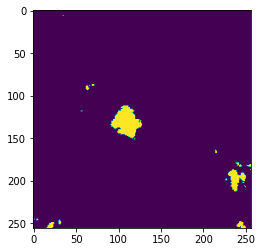

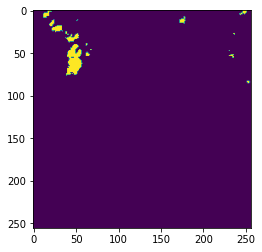

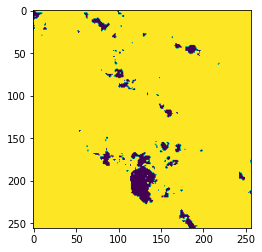

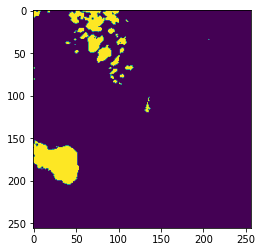

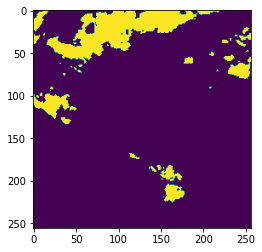

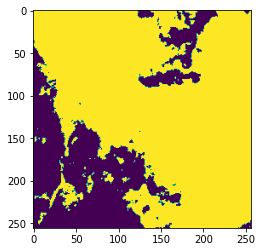

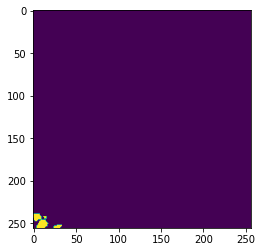

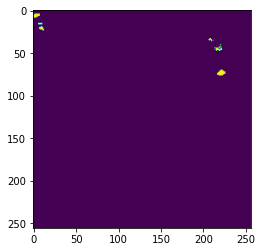

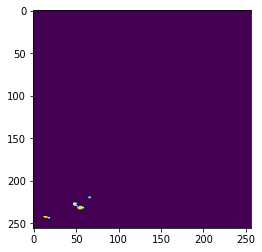

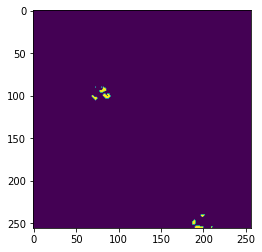

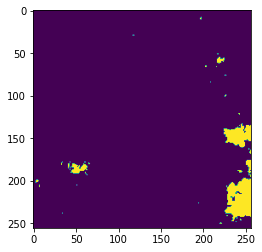

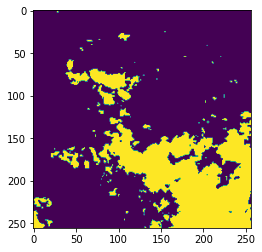

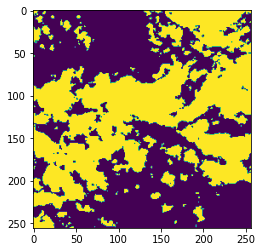

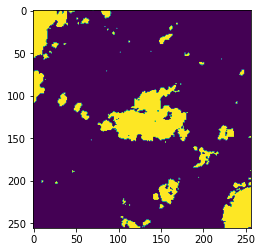

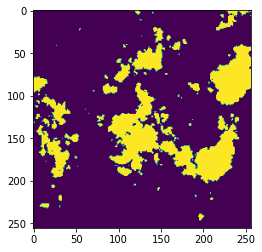

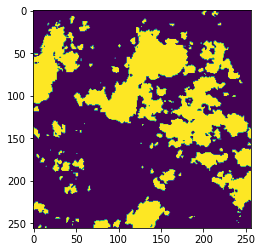

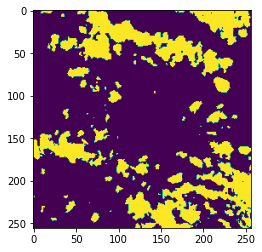

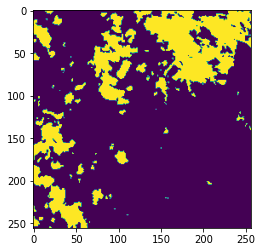

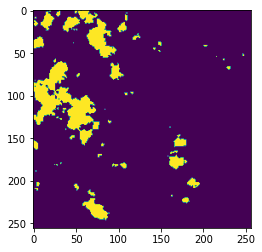

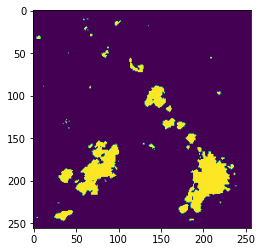

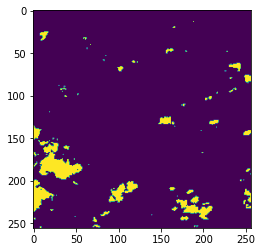

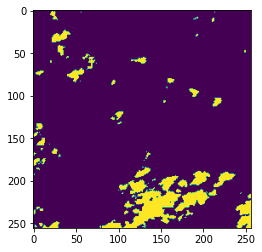

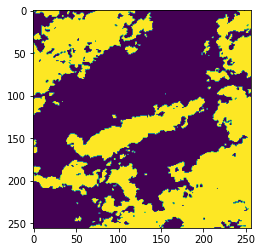

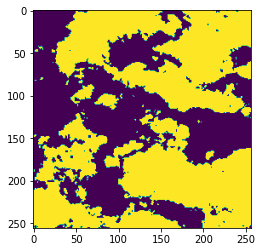

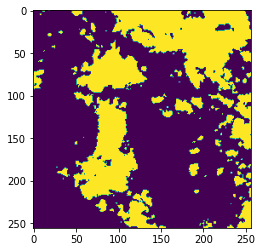

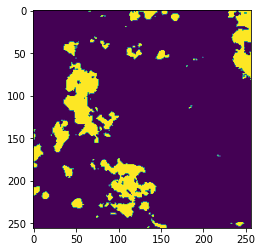

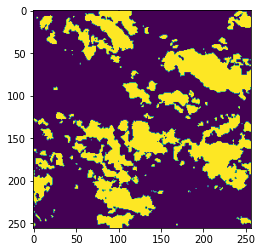

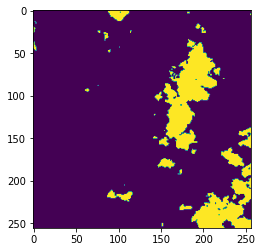

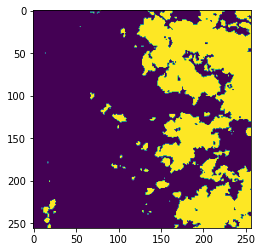

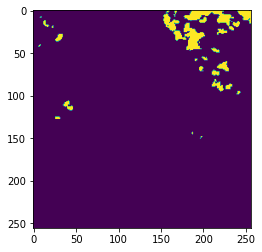

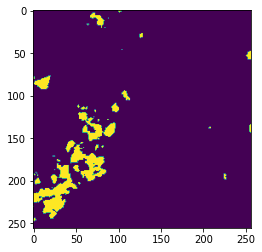

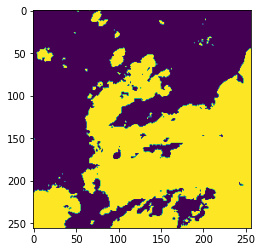

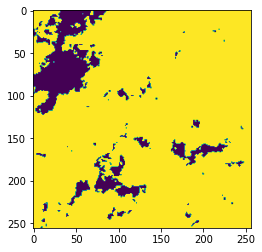

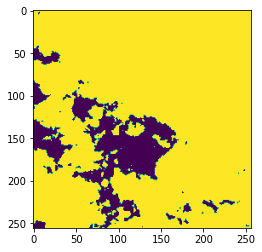

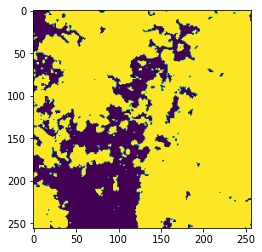

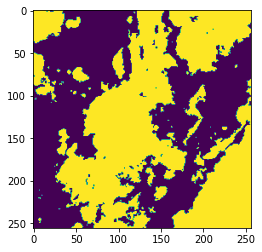

In [ ]:
for pred_image in preds_test_t:
  pred_image_crop = pred_image[:,:,0]
  plt.imshow(pred_image_crop)
  plt.show()